# Setup

In [1]:
from utils import *

# Internal validation

In [2]:
# xsAll = (pd.concat([filt(pd.read_parquet(f)) for f in 
#                     tqdm(glob('data/access_long/*.parquet'))])
#          .astype(D(measure=CAT, geoid=CAT))).disp()
# xsAll.to_parquet('data/access/access_all.parquet', compression='gzip') # 3m31s
xsAll = pd.read_parquet('data/access/access_all.parquet').disp() # 8s

124,074,639 rows x 7 cols; Memory: 2498.2 MiB


,measure,kind,mode,thresh,level,geoid,access
,<category>,<category>,<category>,<category>,<category>,<category>,<float32>
0,Contour,Jobs: All,Drive,15,Tract,13013180103,6590.0


## Consistency across scale

In [3]:
xs_by_scale = []
xs2 = xsAll.query('measure != "2SFCA" & thresh in ("15", "30", "60") & '
                  'kind in ("Jobs: All", "POIs: Total")')
xs2 = xs2.assign(kind=xs2.kind.map({'Jobs: All': 'Jobs', 'POIs: Total': 'POIs'}))
for (measure, kind, mode, thresh), df in tqdm(xs2.groupby(
        ['measure', 'kind', 'mode', 'thresh'], observed=1)):
    for lbig, lsmall, nchar in [('County', 'Tract', 5), ('Tract', 'BG', 11)]:
        xsbig = filt(df, level=lbig).rename(columns=D(access='xsbig'))
        for aggfunc in ['mean', 'median']:
            xssmall = (filt(df, level=lsmall)
                       .assign(geoid=lambda df: df.geoid.str[:nchar])
                       .groupby('geoid').access.agg(aggfunc)
                       .rename('xssmall').reset_index())
            vs = xsbig.merge(xssmall, on='geoid').set_index('geoid')
            xs_by_scale.append(vs.assign(
                lbig=lbig, lsmall=lsmall, measure=measure, kind=kind,
                mode=mode, thresh=thresh, aggfunc=aggfunc.title()))
cat_cols = 'measure kind mode thresh aggfunc lbig lsmall'.split()
xs_by_scale = (pd.concat(xs_by_scale).reset_index(drop=1)
               [cat_cols + ['xsbig', 'xssmall']]
               .astype({x: CAT for x in cat_cols})).disp() # 50s

  0%|          | 0/90 [00:00<?, ?it/s]

6,481,332 rows x 9 cols; Memory: 117.4 MiB


,measure,kind,mode,thresh,aggfunc,lbig,lsmall,xsbig,xssmall
,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<float32>,<float64>
0,Contour,Jobs,Bike,15,Mean,County,Tract,103396.0,56622.308594


In [4]:
rmse = []
grp_cols = 'measure kind mode thresh aggfunc lbig lsmall'.split()
for grp_labels, df in xs_by_scale.groupby(grp_cols, observed=1):
    rmse_value = ((normalize(df.xssmall) - normalize(df.xsbig)) ** 2).mean() ** 0.5
    rmse.append(D(zip(grp_cols, grp_labels)) | D(rmse=rmse_value))
rmse = Pdf(rmse).disp()

360 rows x 8 cols; Memory: 0.1 MiB


,measure,kind,mode,thresh,aggfunc,lbig,lsmall,rmse
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<float64>
0,Contour,Jobs,Bike,15,Mean,County,Tract,0.314961


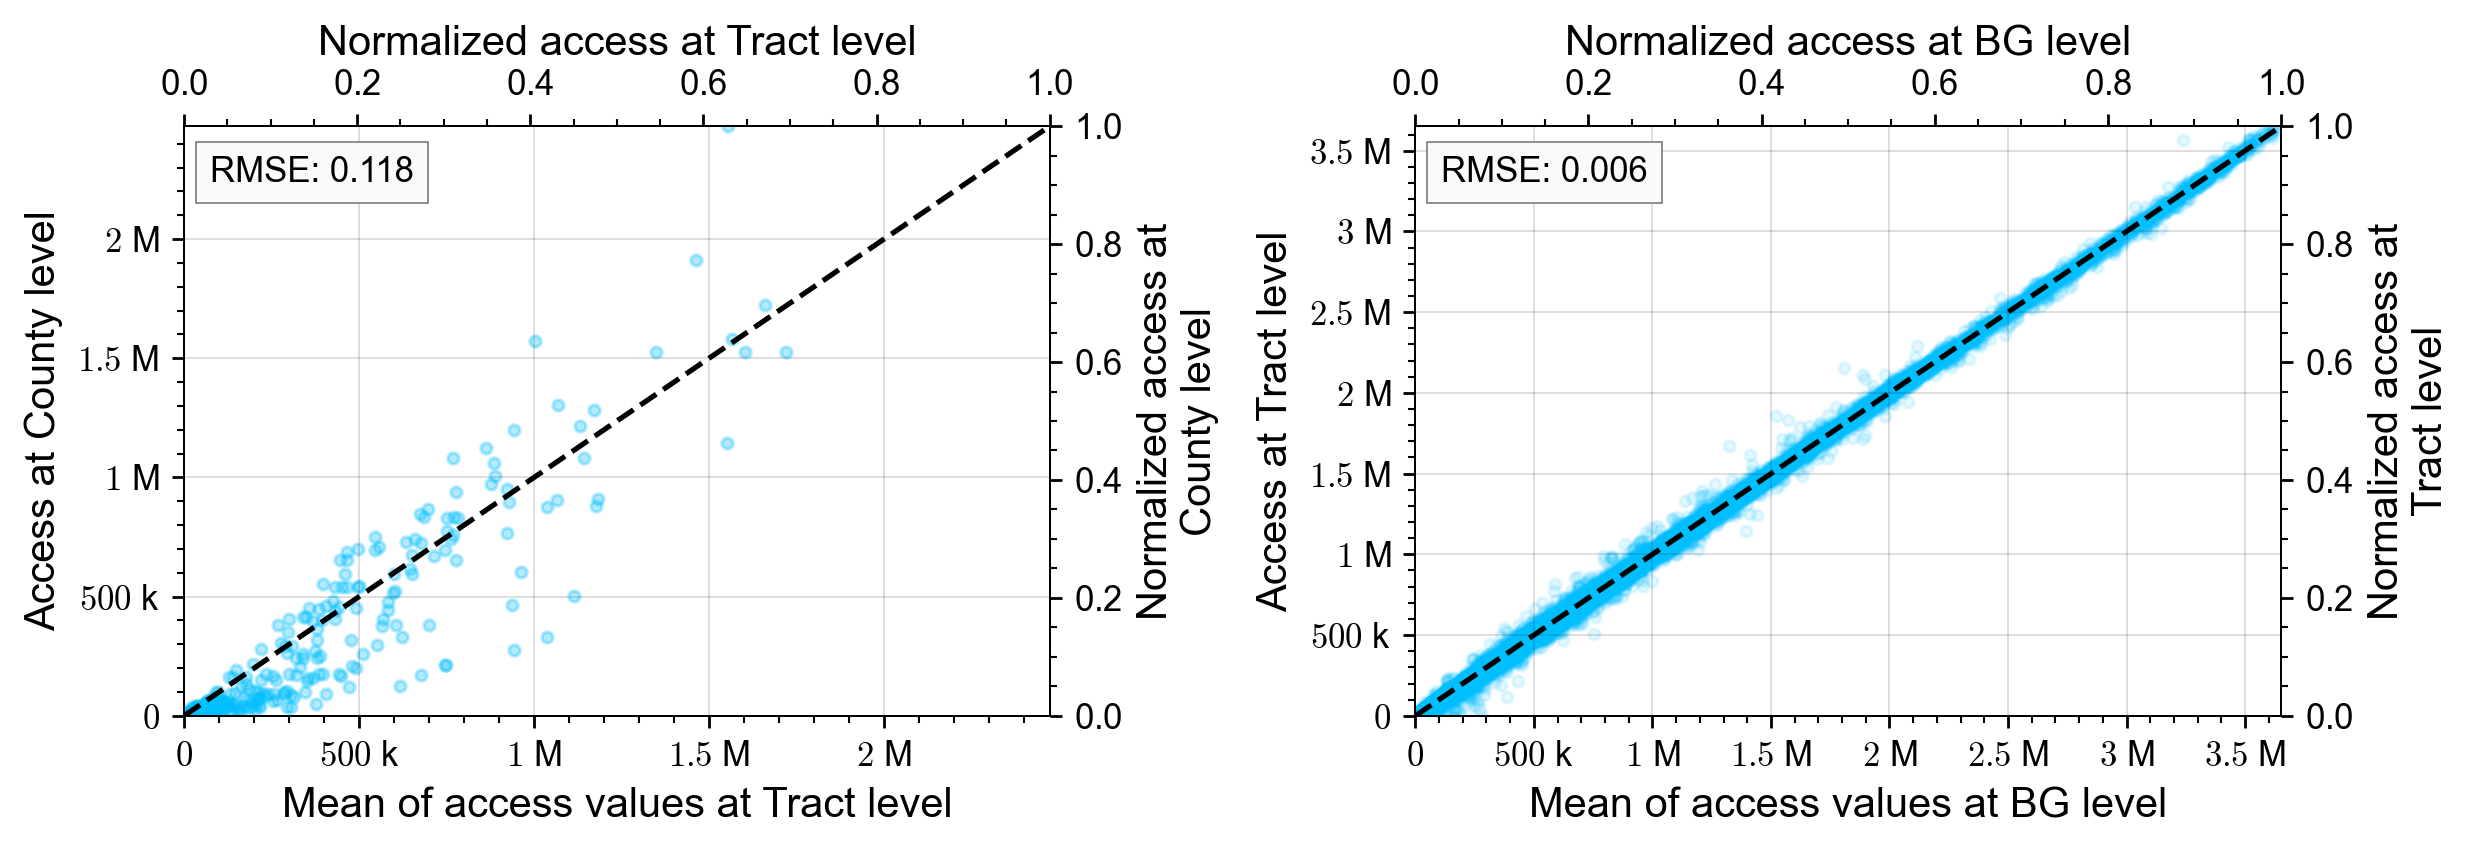

In [5]:
def plot_scale_consistency(
        xs_by_scale=xs_by_scale, measure='Contour', kind='Jobs',
        mode='Drive', thresh='30', aggfunc='Mean', dpi=150):
    vs = filt(xs_by_scale, measure=measure, kind=kind, mode=mode,
              thresh=thresh, aggfunc=aggfunc)
    _, axes = plt.subplots(1, 2, figsize=(10, 3.5), dpi=dpi)
    for ax, (lbig, lsmall, alpha) in zip(axes, [
            ('County', 'Tract', 0.3),
            ('Tract', 'BG', 0.1)]):
        df = filt(vs, lbig=lbig, lsmall=lsmall)
        vmax = df.xsbig.max()
        rmse = ((normalize(df.xssmall) - normalize(df.xsbig)) ** 2).mean() ** 0.5
        ax = plot(ax, xlim=(0, vmax), ylim=(0, vmax), xeng=1, yeng=1)
        ax.set_xlabel(f'Mean of access values at {lsmall} level', fontsize=12)
        ax.set_ylabel(f'Access at {lbig} level', fontsize=12)
        ax.scatter(df.xssmall, df.xsbig, s=10, color='deepskyblue', alpha=alpha)
        ax.plot(*[[0, vmax]] * 2, ls='--', color='k')
        ax.text(0.03, 0.95, f'RMSE: {rmse:.3f}', transform=ax.transAxes, va='top',
                bbox=D(fc='.98', ec='grey', lw=0.5))
        twinx = plot(ax.twinx())
        twinx.set_ylabel(f'Normalized access at\n{lbig} level', fontsize=12)
        twinx.tick_params(which='both', left=False, grid_color='none')
        twiny = plot(ax.twiny())
        twiny.set_xlabel(f'Normalized access at {lsmall} level', fontsize=12)
        twiny.tick_params(which='both', bottom=False, grid_color='none')
    # fig.suptitle(f'Comparison of {aggfunc} {measure} access to '
    #              f'{kind.lower()} by {mode.lower()} within {thresh} minutes')
    plt.tight_layout()

plot_scale_consistency(dpi=250)

In [7]:
# plot_scale_consistency(mode='Walk')

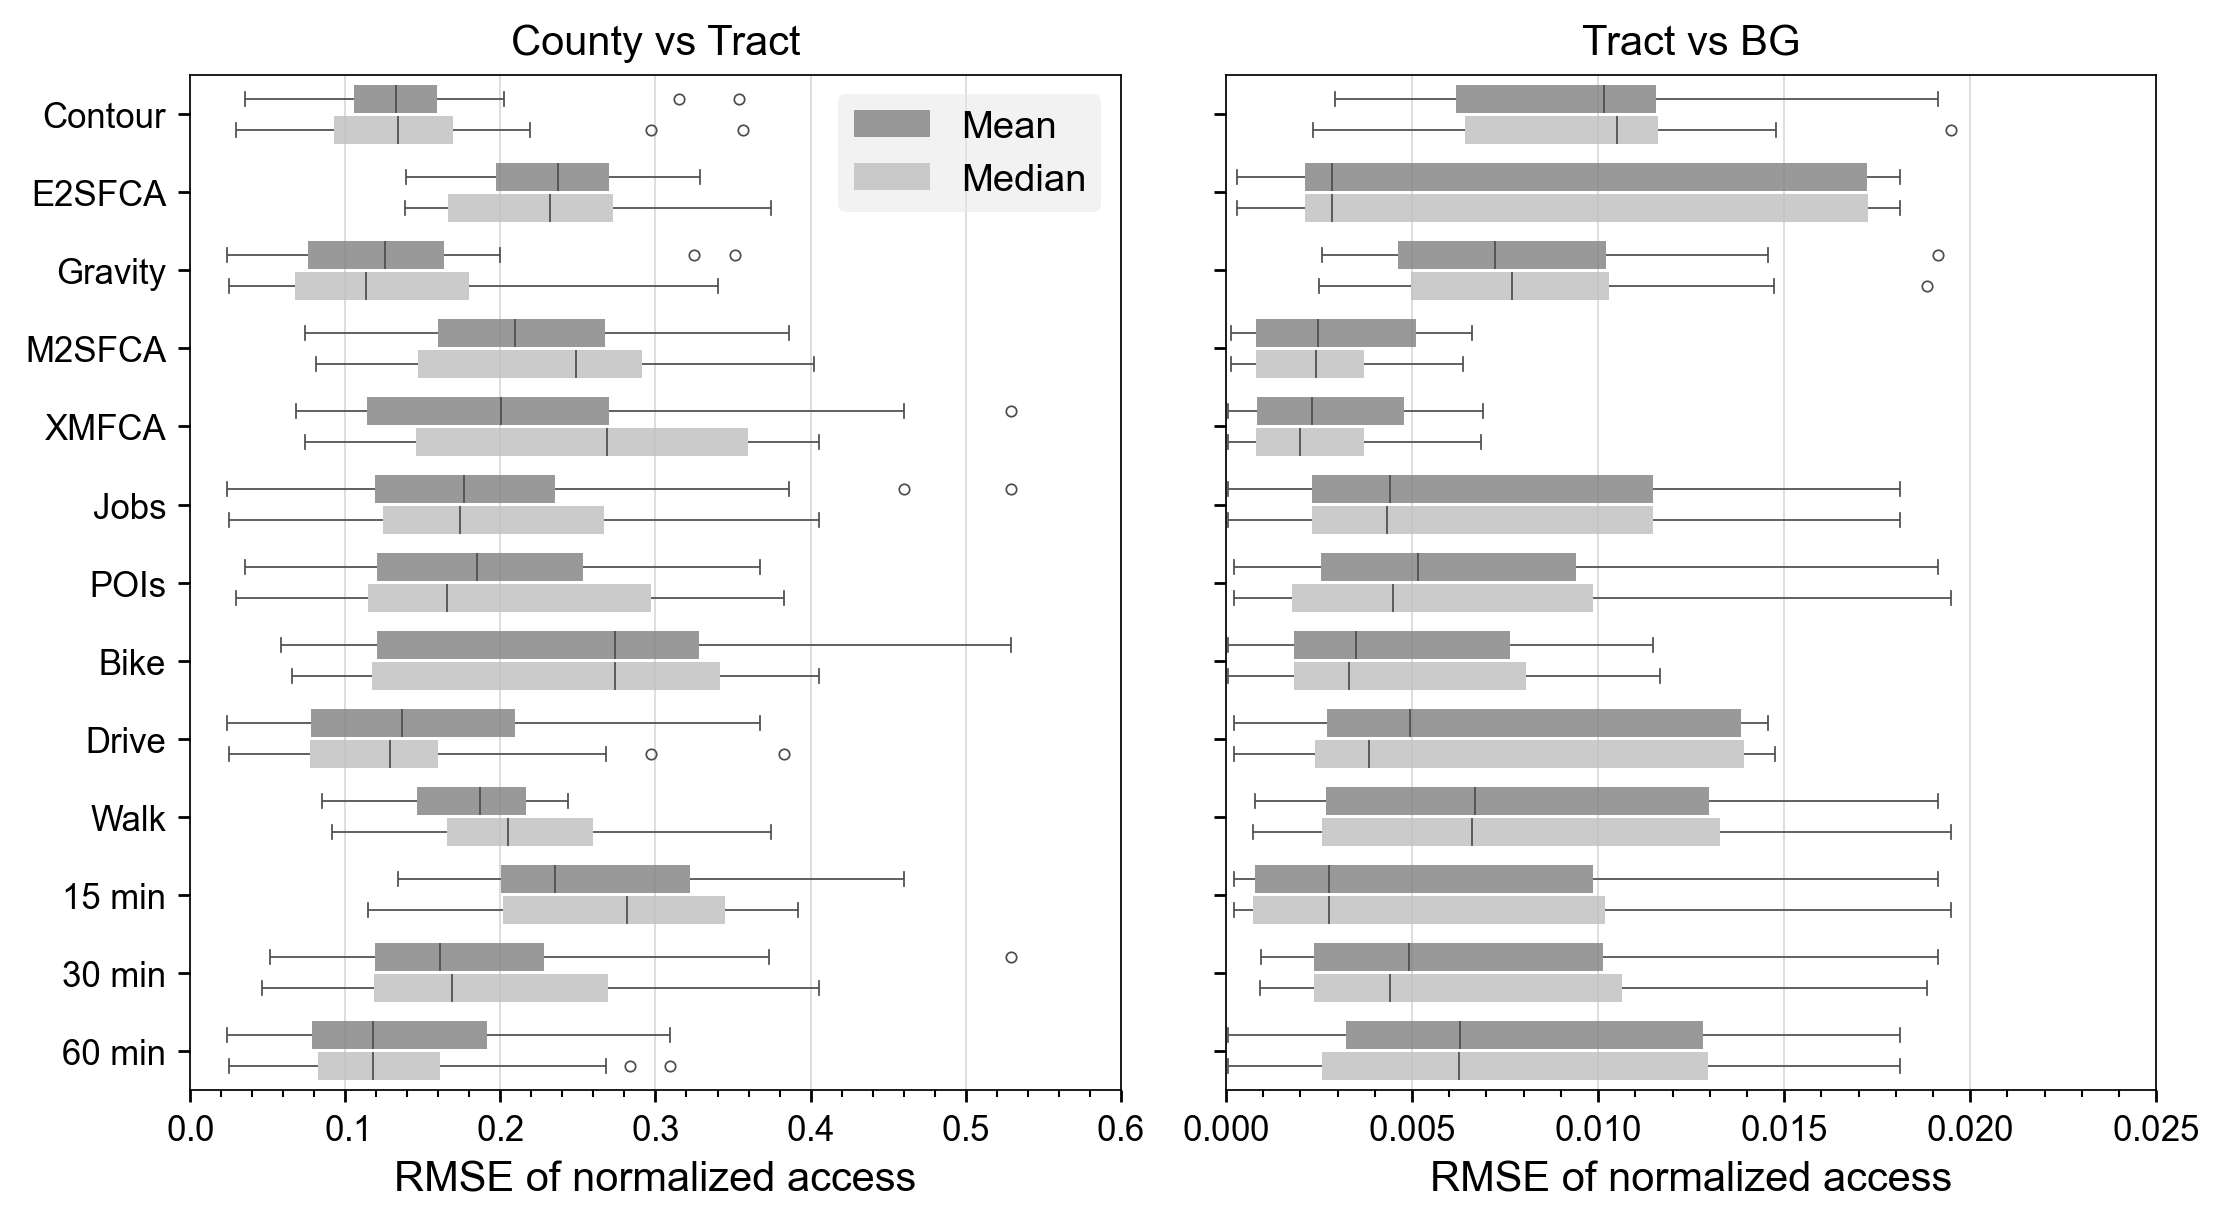

In [6]:
_, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True, dpi=250)
for i, lbig, lsmall, vmax in [(0, 'County', 'Tract', 0.6),
                              (1, 'Tract', 'BG', 0.025)]:
    df = pd.concat([(filt(rmse, lbig=lbig, lsmall=lsmall)
                     .assign(thresh=lambda df: df.thresh + ' min')
                     .rename(columns={col: 'level'}).assign(factor=col))
                    for col in ['measure', 'kind', 'mode', 'thresh']])
    ax = plot(axes[i], yminor=0, xlim=(0, vmax))
    ax.set_title(lbig + ' vs ' + lsmall, fontsize=12)
    ax.set_xlabel('RMSE of normalized access', fontsize=12)
    sns.boxplot(df, ax=ax, y='level', x='rmse', hue='aggfunc', gap=0.1,
                palette=['.5', '.75'], linewidth=0.5,
                fliersize=3, flierprops=D(markeredgewidth=0.5),
                boxprops=D(edgecolor='none', alpha=0.8))
    ax.set_ylabel('')
    ax.get_legend().set_title('')
    if lsmall == 'BG':
        ax.ticklabel_format(axis='x', style='sci', scilimits=[-3, 1])
        ax.get_legend().remove()
plt.tight_layout()
imsave('Distribution of MSE for interscale access consistency by factor')